<a href="https://colab.research.google.com/github/Edenshmuel/ICU_Nutrition_ML/blob/main/Neural_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
!git clone https://github.com/Edenshmuel/ICU_Nutrition_ML.git

fatal: destination path 'ICU_Nutrition_ML' already exists and is not an empty directory.


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Edenshmuel/ICU_Nutrition_ML/refs/heads/main/Food_and_Nutrition__.csv")
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,Calories,Carbohydrates,Fiber,Fat,Breakfast Suggestion,Lunch Suggestion,Dinner Suggestion,Snack Suggestion,Disease
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,2020,250,30.0,60,Oatmeal with berries and nuts,Grilled chicken salad with mixed greens,Salmon with roasted vegetables,Greek yogurt with fruit,Weight Gain
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,1480,200,24.0,40,Tofu scramble with veggies,Lentil soup with whole wheat bread,Vegetable stir-fry with brown rice,Apple with almond butter,"Weight Gain, Hypertension, Heart Disease"
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,2185,300,36.0,65,Tofu and veggie breakfast burrito,Black bean burger on a whole wheat bun,Lentil and vegetable curry,Trail mix,Weight Gain
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,2680,350,42.0,80,Greek yogurt with granola and fruit,Chicken and vegetable stir-fry,Turkey chili with brown rice,Banana with peanut butter,Weight Gain
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,1815,250,30.0,55,Scrambled eggs with whole wheat toast and avocado,Quinoa salad with chickpeas and vegetables,Vegetarian chili with cornbread,Fruit and nut mix,Weight Gain


**Define Features and Target Variable**

In [4]:
X = df.drop(columns=["Daily Calorie Target", "Protein", "Carbohydrates"])
y = df[["Daily Calorie Target", "Protein", "Carbohydrates"]]

**Feature Selection**

Prevent Data Leakage: Remove Columns That Contain Target Information

In [5]:
X = df.drop(columns=["Calories"])

Removing Non-Contributing Columns

In [6]:
columns_to_remove = ["Sugar" , "Fiber", "Sodium", "Breakfast Suggestion", "Lunch Suggestion",
                     "Dinner Suggestion", "Snack Suggestion"]

X = df.drop(columns=columns_to_remove)

**Categorize Features: Numerical, Categorical, and Skewed Columns**

In [6]:
numerical_features = ["Ages", "Height", "Weight"]
categorical_features = ["Gender", "Activity Level", "Dietary Preference", "Disease"]

Features identified as right-skewed from EDA; applying log transformation

In [7]:
right_skewed_features = ["Fat"]

**Data Preprocessing: Pipelines for Scaling, Encoding, and Log Transformation**

Log Transform + Scaling for skewed features

In [8]:
log_scaler_pipeline = Pipeline(steps=[("log_transform", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler())])

Standard Scaling for non-skewed features

In [9]:
scaler_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

One-Hot Encoding for categorical features

In [10]:
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

Combine Transformations in ColumnTransformer

**Define a Custom Transformer for BMI Calculation**

In [11]:
class BMICalculator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["BMI"] = X["Weight"] / (X["Height"] ** 2)
        return X

In [12]:
num_pipeline = Pipeline(steps=[
    ("bmi_calculator", BMICalculator()),
    ("log_scaled", log_scaler_pipeline),
    ("scaler", scaler_pipeline)])

In [13]:
preprocessor = ColumnTransformer(transformers=[
    ("log_scaled", log_scaler_pipeline, right_skewed_features),
    ("scaled", scaler_pipeline, list(numerical_features)),
    ("cat", cat_transformer, categorical_features)])

Split data before applying transformations to prevent data leakage

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply the pipeline

In [15]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [16]:
print(f"✅ Training Data Processed: {X_train_transformed.shape} (Rows, Features)")
print(f"✅ Test Data Processed: {X_test_transformed.shape} (Rows, Features)")

✅ Training Data Processed: (1358, 28) (Rows, Features)
✅ Test Data Processed: (340, 28) (Rows, Features)


**Baseline Model**

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [18]:
y_test_copy = np.array(copy.deepcopy(y_test))

np.random.shuffle(y_test_copy)

random_baseline_mae = mean_absolute_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_mse = mean_squared_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_rmse = np.sqrt(random_baseline_mse)
random_baseline_r2 = r2_score(y_test, y_test_copy, multioutput="raw_values")

print(f"Random Baseline MAE per target: {random_baseline_mae}")
print(f"Average Random Baseline MAE: {random_baseline_mae.mean():.2f}")

print(f"Random Baseline MSE per target: {random_baseline_mse}")
print(f"Average Random Baseline MSE: {random_baseline_mse.mean():.2f}")

print(f"Random Baseline RMSE per target: {random_baseline_rmse}")
print(f"Average Random Baseline RMSE: {random_baseline_rmse.mean():.2f}")

print(f"Random Baseline R² per target: {random_baseline_r2}")
print(f"Average Random Baseline R²: {random_baseline_r2.mean():.2f}")

Random Baseline MAE per target: [631.62352941  58.01176471  82.82941176]
Average Random Baseline MAE: 257.49
Random Baseline MSE per target: [637653.02941176   5360.05294118  10613.26470588]
Average Random Baseline MSE: 217875.45
Random Baseline RMSE per target: [798.53179612  73.21238243 103.02070038]
Average Random Baseline RMSE: 324.92
Random Baseline R² per target: [-0.94462912 -0.94341648 -1.03530243]
Average Random Baseline R²: -0.97


**Neural Network Model**

In [19]:
!pip install scikit-learn==1.3.1

In [20]:
!pip install --upgrade scikit-learn scikeras --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 52.1 MB/s eta 0:00:00


In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [22]:
y_train_np = y_train.to_numpy()

In [94]:
# הגדרת Learning Rate עם Exponential Decay
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,  # קצב למידה התחלתי
    decay_steps=1000,            # כל כמה צעדים להוריד את קצב הלמידה
    decay_rate=0.96,             # קצב הפחתה (96% מכל שלב קודם)
    staircase=True               # מפחית בקפיצות ולא באופן רציף
)

In [95]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_transformed.shape[1],)),
        BatchNormalization(),  # עוזר לייצב את האימון ולהאיץ למידה
        Dropout(0.2),  # משמיט 30% מהנוירונים כדי למנוע Overfitting

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(y_train.shape[1], activation='linear')  # שכבת פלט - ערכים רציפים
    ])

    optimizer = Adam(learning_rate=lr_schedule)  # שימוש ב-Decay בתוך ה-Adam Optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
# הגדרת K-Fold
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# רשימה לאחסון MAE לכל עמודה
mae_per_column = []

early_stopping = EarlyStopping(
    monitor='val_loss',  # עקוב אחרי השגיאה של קבוצת הולידציה
    patience=7,          # עצור אם אין שיפור במשך 5 epochs רצופים
    restore_best_weights=True  # החזר את המשקלים הכי טובים אחרי העצירה
)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# ביצוע K-Fold Cross Validation
for train_idx, val_idx in kfold.split(X_train_transformed):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]  # שימוש במערך NumPy

    # יצירת מודל חדש לכל קיפול
    model = build_model()

    # אימון המודל עם EarlyStopping
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=16, verbose=1,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    # חיזוי על קבוצת הולידציה
    y_val_pred = model.predict(X_val_fold)

    # חישוב MAE לכל עמודה בנפרד
    fold_mae_per_column = mean_absolute_error(y_val_fold, y_val_pred, multioutput="raw_values")

    # שמירת השגיאות של כל קיפול
    mae_per_column.append(fold_mae_per_column)

    print(f"MAE לכל עמודה בקיפול נוכחי: {fold_mae_per_column}")

# המרת הרשימה למערך numpy
mae_per_column = np.array(mae_per_column)

# ממוצע MAE לכל עמודה
mean_mae_per_column = mae_per_column.mean(axis=0)

# הדפסת התוצאות הסופיות
print("\nMAE ממוצע לכל עמודה:")
for i, col_name in enumerate(["קלוריות", "פחמימות", "חלבון"]):  # עדכן לפי סדר הנתונים שלך
    print(f"{col_name}: {mean_mae_per_column[i]:.2f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1811701.7500 - mae: 875.5502 - val_loss: 1884967.7500 - val_mae: 896.2278
Epoch 2/50
51/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1793226.2500 - mae: 861.4978

Plot Training vs. Validation Loss

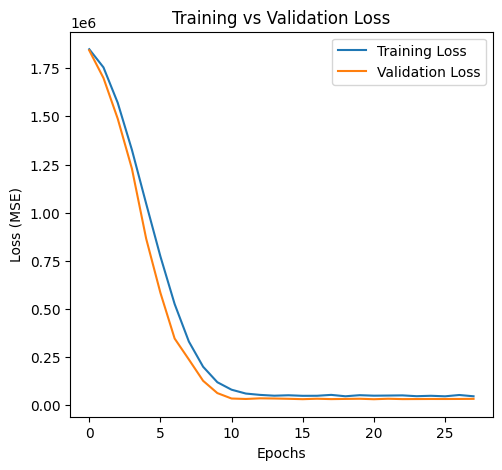

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss גרף
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()

Define and train the Neural Network

In [93]:
y_test_pred = model.predict(X_test_transformed)

# חישוב מדדים
test_mae = mean_absolute_error(y_test, y_test_pred, multioutput="raw_values")
test_mse = mean_squared_error(y_test, y_test_pred, multioutput="raw_values")
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred, multioutput="raw_values")


# הדפסת תוצאות השוואה
print("\n🔹 **השוואת ביצועי המודל מול הבייסליין** 🔹")

print("\n📊 **MAE** (שגיאה מוחלטת ממוצעת):")
print(f"Random Baseline: {np.round([631.62, 58.01, 82.83], 2)}")
print(f"Model Performance: {np.round(test_mae, 2)}")

print("\n📊 **MSE** (שגיאת ריבוע ממוצעת):")
print(f"Random Baseline: {np.round([637653.03, 5360.05, 10613.26], 2)}")
print(f"Model Performance: {np.round(test_mse, 2)}")

print("\n📊 **RMSE** (שורש שגיאת ריבוע ממוצעת):")
print(f"Random Baseline: {np.round([798.53, 73.21, 103.02], 2)}")
print(f"Model Performance: {np.round(test_rmse, 2)}")

print("\n📊 **R²** (אחוז השונות שהמודל מסביר):")
print(f"Random Baseline: {np.round([-0.94, -0.94, -1.03], 2)}")
print(f"Model Performance: {np.round(test_r2, 2)}")

# השוואת ממוצעים
print("\n📊 **השוואת ממוצע המדדים בין המודל לבייסליין:**")
print(f"Average Random Baseline MAE: {np.round(257.49, 2)}, Model MAE: {np.round(test_mae.mean(), 2)}")
print(f"Average Random Baseline MSE: {np.round(217875.45, 2)}, Model MSE: {np.round(test_mse.mean(), 2)}")
print(f"Average Random Baseline RMSE: {np.round(324.92, 2)}, Model RMSE: {np.round(test_rmse.mean(), 2)}")
print(f"Average Random Baseline R²: {np.round(-0.97, 2)}, Model R²: {np.round(test_r2.mean(), 2)}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

🔹 **השוואת ביצועי המודל מול הבייסליין** 🔹

📊 **MAE** (שגיאה מוחלטת ממוצעת):
Random Baseline: [631.62  58.01  82.83]
Model Performance: [241.06  27.11  39.11]

📊 **MSE** (שגיאת ריבוע ממוצעת):
Random Baseline: [637653.03   5360.05  10613.26]
Model Performance: [117190.77   1053.75   2953.12]

📊 **RMSE** (שורש שגיאת ריבוע ממוצעת):
Random Baseline: [798.53  73.21 103.02]
Model Performance: [342.33  32.46  54.34]

📊 **R²** (אחוז השונות שהמודל מסביר):
Random Baseline: [-0.94 -0.94 -1.03]
Model Performance: [0.64 0.62 0.43]

📊 **השוואת ממוצע המדדים בין המודל לבייסליין:**
Average Random Baseline MAE: 257.49, Model MAE: 102.43
Average Random Baseline MSE: 217875.45, Model MSE: 40399.21
Average Random Baseline RMSE: 324.92, Model RMSE: 143.05
Average Random Baseline R²: -0.97, Model R²: 0.56
